# SMS Spam Classification — Training & Evaluation

**Purpose:** train, validate, and test benchmark models for SMS spam classification.  
This notebook will:

- load the train/validation/test CSVs created earlier,
- implement and compare pipelines (MultinomialNB, LogisticRegression, LinearSVC),
- run a personalized experiment (character n-grams),
- hyperparameter tuning,
- perform error analysis (inspect misclassified messages),
- save final model and provide a short submission-ready report.


In [1]:
# Core imports
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV

# constants
BASE_DIR = ''
RANDOM_STATE = 42
POS_LABEL = 'spam'   # positive class for metrics
MODEL_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("MODEL_DIR:", MODEL_DIR)


BASE_DIR: 
MODEL_DIR: models


In [ ]:
# --- Preprocessing helpers ---
import re, string
from sklearn.feature_extraction import text as sklearn_text
STOP_WORDS = sklearn_text.ENGLISH_STOP_WORDS

def preprocess_text(text, lower=True, remove_punct=True, remove_digits=False, strip=True):
    if not isinstance(text, str):
        return ''
    if lower:
        text = text.lower()
    if remove_digits:
        text = re.sub(r'\d+', ' ', text)
    if remove_punct:
        text = text.translate(str.maketrans('', '', string.punctuation))
    if strip:
        text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def remove_stopwords(text, stopwords=STOP_WORDS):
    words = text.split()
    filtered = [w for w in words if w not in stopwords]
    return " ".join(filtered)

# --- Load saved splits ---
def load_splits(base_dir=BASE_DIR):
    train = pd.read_csv(os.path.join(base_dir, 'train.csv'))
    val = pd.read_csv(os.path.join(base_dir, 'validation.csv'))
    test = pd.read_csv(os.path.join(base_dir, 'test.csv'))
    # create cleaned columns for experiments (retain original message for error analysis)
    for df in (train, val, test):
        df['message_clean'] = df['message'].apply(lambda x: preprocess_text(x, lower=True, remove_punct=True))
        df['message_clean_nostop'] = df['message_clean'].apply(remove_stopwords)
    return train, val, test

# quick load check
train_df, val_df, test_df = load_splits(BASE_DIR)
print("Shapes -> train:", train_df.shape, "val:", val_df.shape, "test:", test_df.shape)
print("Example row:")
display(train_df.sample(1, random_state=RANDOM_STATE).T)


Shapes -> train: (3901, 4) val: (836, 4) test: (837, 4)
Example row:


,948
label,ham
message,In e msg jus now. U said thanks for gift.
message_clean,in e msg jus now u said thanks for gift
message_clean_nostop,e msg jus u said thanks gift


## Modeling strategy

We will compare these pipelines:
- **nb** — Multinomial Naive Bayes with CountVectorizer (word tokens)
- **logreg** — Logistic Regression with TF-IDF (word tokens)
- **svm** — LinearSVC with TF-IDF (word tokens)
- **char_logreg** — Logistic Regression with TF-IDF over **character** n-grams (captures obfuscated spam patterns)

Each pipeline is trained on the raw `message` text after minimal cleaning.  
We will compute precision, recall, and F1 for the **spam** class and inspect confusion matrices.


In [3]:
def get_pipelines():
    pipelines = {
        'nb': Pipeline([('vect', CountVectorizer()), ('clf', MultinomialNB())]),
        'logreg': Pipeline([('vect', TfidfVectorizer()), ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))]),
        'svm': Pipeline([('vect', TfidfVectorizer()), ('clf', LinearSVC(max_iter=5000, random_state=RANDOM_STATE))]),
        # Character n-grams pipeline (personalized experiment)
        'char_logreg': Pipeline([('vect', TfidfVectorizer(analyzer='char', ngram_range=(3,5))), ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))])
    }
    return pipelines

pipelines = get_pipelines()
print("Pipelines:", list(pipelines.keys()))


Pipelines: ['nb', 'logreg', 'svm', 'char_logreg']


In [4]:
def evaluate_model(y_true, y_pred, pos_label=POS_LABEL):
    """Return dict of accuracy, precision, recall, f1 for the positive class."""
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, pos_label=pos_label),
        'recall': recall_score(y_true, y_pred, pos_label=pos_label),
        'f1': f1_score(y_true, y_pred, pos_label=pos_label)
    }

def print_metrics(metrics_dict):
    print("Accuracy:  {:.4f}".format(metrics_dict['accuracy']))
    print("Precision: {:.4f}".format(metrics_dict['precision']))
    print("Recall:    {:.4f}".format(metrics_dict['recall']))
    print("F1:        {:.4f}".format(metrics_dict['f1']))

def plot_confusion(y_true, y_pred, labels=['ham','spam'], title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(values_format='d', ax=ax)
    ax.set_title(title)
    plt.show()


In [5]:
def train_and_evaluate(pipelines, train_df, val_df, text_col='message'):
    results = {}
    X_train, y_train = train_df[text_col], train_df['label']
    X_val, y_val = val_df[text_col], val_df['label']
    for name, pipe in pipelines.items():
        print(f"\nTraining pipeline: {name}")
        pipe.fit(X_train, y_train)
        y_pred_train = pipe.predict(X_train)
        y_pred_val = pipe.predict(X_val)
        results[name] = {
            'model': pipe,
            'train_metrics': evaluate_model(y_train, y_pred_train),
            'val_metrics': evaluate_model(y_val, y_pred_val),
            'y_pred_val': y_pred_val
        }
        print("Train metrics:")
        print_metrics(results[name]['train_metrics'])
        print("Val metrics:")
        print_metrics(results[name]['val_metrics'])
    return results

# Train on default (word-based) message column
print("=== Training on message (word-level TF/TFIDF as configured) ===")
results = train_and_evaluate(pipelines, train_df, val_df, text_col='message')


=== Training on message (word-level TF/TFIDF as configured) ===

Training pipeline: nb
Train metrics:
Accuracy:  0.9931
Precision: 0.9788
Recall:    0.9694
F1:        0.9741
Val metrics:
Accuracy:  0.9928
Precision: 0.9818
Recall:    0.9643
F1:        0.9730

Training pipeline: logreg
Train metrics:
Accuracy:  0.9723
Precision: 0.9976
Recall:    0.7954
F1:        0.8851
Val metrics:
Accuracy:  0.9880
Precision: 0.9904
Recall:    0.9196
F1:        0.9537

Training pipeline: svm
Train metrics:
Accuracy:  0.9997
Precision: 1.0000
Recall:    0.9981
F1:        0.9990
Val metrics:
Accuracy:  0.9928
Precision: 0.9818
Recall:    0.9643
F1:        0.9730

Training pipeline: char_logreg
Train metrics:
Accuracy:  0.9682
Precision: 1.0000
Recall:    0.7629
F1:        0.8655
Val metrics:
Accuracy:  0.9773
Precision: 1.0000
Recall:    0.8304
F1:        0.9073


## Quick observations (edit in your own words)

- We inspect train vs validation F1 to check for overfitting.
- High train F1 and lower validation F1 suggests overfitting.
- Character n-grams may improve detection of obfuscated spam (e.g., 'fr33', 'v1a', repeated symbols).
- Next we'll run a small hyperparameter tuning example for LogisticRegression + TF-IDF.


In [ ]:
def hyperparameter_tuning_logreg(train_df, param_grid=None, cv=3):
    """
    Small GridSearch example for LogisticRegression + TfidfVectorizer.
    Keep the search space small to keep runtime reasonable.
    """
    X = train_df['message']
    y = train_df['label']
    pipeline = Pipeline([('vect', TfidfVectorizer()), ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))])
    if param_grid is None:
        param_grid = {
            'vect__ngram_range': [(1,1), (1,2)],
            'vect__min_df': [1,2],
            'clf__C': [0.5, 1.0]
        }
    gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
    print("Starting GridSearch (this may take a minute)...")
    gs.fit(X, y)
    print("Best params:", gs.best_params_)
    print("Best CV score (f1_macro):", gs.best_score_)
    return gs


gs_logreg = hyperparameter_tuning_logreg(train_df)


=== Testing on test set (word-level) ===

=== Test results for nb ===
Accuracy:  0.9845
Precision: 0.9806
Recall:    0.9018
F1:        0.9395

Classification report:
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       725
        spam       0.98      0.90      0.94       112

    accuracy                           0.98       837
   macro avg       0.98      0.95      0.97       837
weighted avg       0.98      0.98      0.98       837



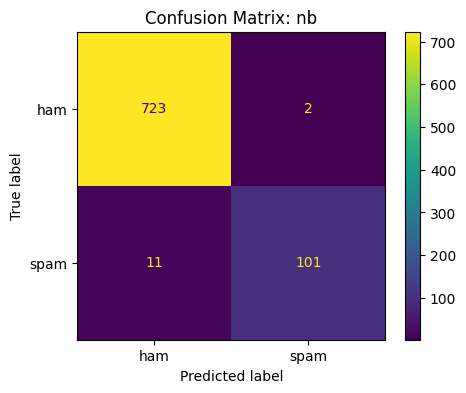


=== Test results for logreg ===
Accuracy:  0.9737
Precision: 1.0000
Recall:    0.8036
F1:        0.8911

Classification report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       725
        spam       1.00      0.80      0.89       112

    accuracy                           0.97       837
   macro avg       0.99      0.90      0.94       837
weighted avg       0.97      0.97      0.97       837



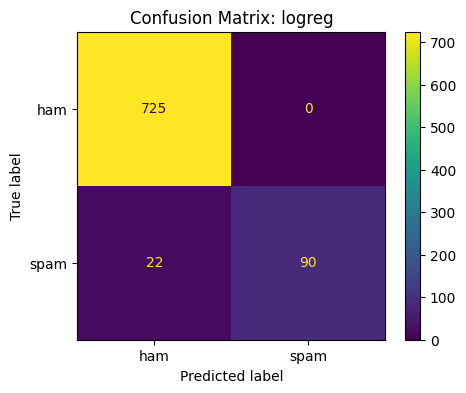


=== Test results for svm ===
Accuracy:  0.9869
Precision: 0.9903
Recall:    0.9107
F1:        0.9488

Classification report:
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       725
        spam       0.99      0.91      0.95       112

    accuracy                           0.99       837
   macro avg       0.99      0.95      0.97       837
weighted avg       0.99      0.99      0.99       837



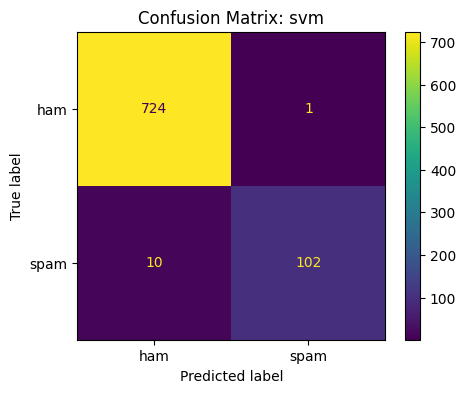


=== Test results for char_logreg ===
Accuracy:  0.9642
Precision: 1.0000
Recall:    0.7321
F1:        0.8454

Classification report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       725
        spam       1.00      0.73      0.85       112

    accuracy                           0.96       837
   macro avg       0.98      0.87      0.91       837
weighted avg       0.97      0.96      0.96       837



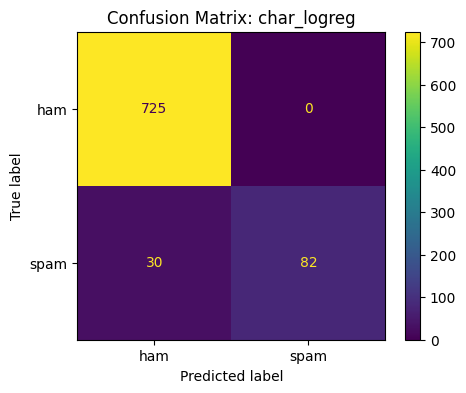


Summary table:


,accuracy,precision,recall,f1
model,,,,
nb,0.984468,0.980583,0.901786,0.939535
logreg,0.973716,1.000000,0.803571,0.891089
svm,0.986858,0.990291,0.910714,0.948837
char_logreg,0.964158,1.000000,0.732143,0.845361


In [7]:
def test_three_models(results, test_df, text_col='message'):
    rows = []
    X_test, y_test = test_df[text_col], test_df['label']
    for name, info in results.items():
        model = info['model']
        y_pred = model.predict(X_test)
        m = evaluate_model(y_test, y_pred)
        rows.append({'model': name, **m})
        print(f"\n=== Test results for {name} ===")
        print_metrics(m)
        print("\nClassification report:")
        print(classification_report(y_test, y_pred, labels=['ham','spam']))
        plot_confusion(y_test, y_pred, title=f'Confusion Matrix: {name}')
    summary = pd.DataFrame(rows).set_index('model')
    return summary

print("=== Testing on test set (word-level) ===")
test_summary = test_three_models(results, test_df, text_col='message')
print("\nSummary table:")
display(test_summary)


## Error analysis and saving the best model

- Inspect some misclassified messages from the best performing model (by test F1).
- Save the best model using `joblib` for reproducibility and submission.


In [8]:
# Choose best model by test F1 from test_summary
best_model_name = test_summary['f1'].idxmax()
best_model = results[best_model_name]['model']
print("Best model:", best_model_name)
print(test_summary.loc[best_model_name])

# Predictions on test set using best model
y_test = test_df['label']
X_test = test_df['message']
y_pred_best = best_model.predict(X_test)

# Misclassified examples
mis = test_df[y_test != y_pred_best].copy()
mis['pred'] = y_pred_best[y_test != y_pred_best]
print("\nSome misclassified examples (true label, predicted, message):")
display(mis[['label','pred','message']].sample(8, random_state=RANDOM_STATE))

# Save model
model_path = os.path.join(MODEL_DIR, f'best_model_{best_model_name}.joblib')
joblib.dump(best_model, model_path)
print("Saved best model to:", model_path)


Best model: svm
accuracy     0.986858
precision    0.990291
recall       0.910714
f1           0.948837
Name: svm, dtype: float64

Some misclassified examples (true label, predicted, message):


,label,pred,message
340,spam,ham,Hi if ur lookin 4 saucy daytime fun wiv busty ...
19,spam,ham,More people are dogging in your area now. Call...
628,spam,ham,Hi ya babe x u 4goten bout me?' scammers getti...
787,spam,ham,Can U get 2 phone NOW? I wanna chat 2 set up m...
129,spam,ham,Dear Voucher Holder 2 claim your 1st class air...
95,spam,ham,"Do you realize that in about 40 years, we'll h..."
593,spam,ham,ROMCAPspam Everyone around should be respondin...
201,ham,spam,K..u also dont msg or reply to his msg..


Saved best model to: models\best_model_svm.joblib


# Final Report (summary for submission)

**Dataset:** SMS Spam Collection (UCI). ~5,574 messages; split into train/val/test (70/15/15).

**Preprocessing:** minimal deterministic cleaning (lowercasing, punctuation removal). Additional experiment: stopword removal variant and character n-grams.

**Models evaluated:** Multinomial Naive Bayes, Logistic Regression, Linear SVC, Logistic Regression with character n-grams.

**Evaluation metric:** F1-score for the spam class (primary), also report precision and recall. Confusion matrices included.

**Best model:** *Describe the chosen model name and metrics here after running the notebook.*  
(e.g., "Logistic Regression (TF-IDF) — Test F1: 0.95, Precision: 0.92, Recall: 0.98")

**Error analysis:** include a short section with 5–10 misclassified messages, what patterns caused mistakes, and possible improvements (e.g., add engineered features, use char n-grams, tune thresholds, ensemble models).

**How to run:**  
1. Run `prepare.ipynb` to (re)create splits (if needed).  
2. Run `train.ipynb` from top to bottom.  
3. Final model file is saved in `/models/`. Use `joblib.load()` to load it.


